#Password Analysis

Below analyzes 2m passwords hacked from Yahoo and released publicly.  We'll look at the most common password length and characters, as well as popular phrases (love, man, wang, dragon, windows, pass).

As an aside, password length trumps complexity.  Hackers have already catalogued short 8 character passwords into rainbow hash tables as discussed here
https://medium.com/policygenius-stories/the-sophisticates-guide-to-passwords-4bb6b5d9ecb5.

In [17]:
#initialize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

###Import data

In [2]:
%%time
df = pd.read_table('http://datashaping.com/passwords.txt',skiprows=16,names=(['pw']),quoting=3)  # nrows=10
print('passwords = ',"{:,}".format(df.pw.size)
      ,'\ndups = ',df.pw.size - df.pw.unique().size
      ,'\ntotalCharacters = ',"{:,}".format(len(df.pw.str.cat())))

passwords =  2,151,220 
dups =  399 
totalCharacters =  18,011,567
Wall time: 5.01 s


In [4]:
print(df.head())
print(df.tail())

             pw
0   07606374520
1  piontekendre
2      rambo144
3     primoz123
4       sal1387
                  pw
2151215     26778982
2151216      brazer1
2151217   usethisone
2151218  scare222273
2151219     anto1962


### Password Length

most common length:  8.0 characters


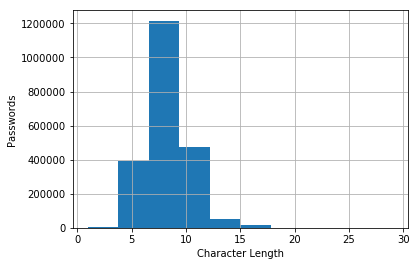

In [7]:
# How many characters do most people use?
df['pwlength']=df.pw.str.len()
pp = df['pwlength'].hist()
z = pp.set_xlabel("Character Length")
z = pp.set_ylabel("Passwords")
print('most common length: ',df['pwlength'].mode().max(), 'characters')

In [9]:
#Look at some of the longest and shortest passwords
print(df.sort_values(by='pwlength',ascending=False).head())
print(df.sort_values(by='pwlength').head())

                                    pw  pwlength
120304   waaaaaaaaaaaaaaaaaaaaaaaaaaaa      29.0
1155769  @fytEm10 *Vb^mZ3%100iRt3h1337      29.0
1165598  babi punyer encryptor haihhhh      29.0
254206   IhanVitunPitkaSalasanaSaakeli      29.0
457967   a42bdef285d431054f2848d30afac      29.0
        pw  pwlength
358891   a       1.0
1688806  9       1.0
1078081  7       1.0
622400   Y       1.0
1266307  J       1.0


### Characters Used

In [11]:
# what alpha character is most often used?
import nltk

def printMostCommon(n):
    df2 = pd.DataFrame(fdist.most_common(n))
    df2.columns = ['char','freq']
    df2['occurence']= df2.freq / len(df.pw.str.cat()) # % of all characters
    return df2
    
fdist = nltk.FreqDist(ch.lower() for ch in df.pw.str.cat() if ch.isalpha())
printMostCommon(3)[['char','occurence']]

,char,occurence
0,a,0.059467
1,e,0.045304
2,i,0.040045


In [18]:
type(fdist)
type(fdist.most_common(3))
# pd.DataFrame(fdist).head(10)

nltk.probability.FreqDist

list

In [ ]:
#most common digits
fdist = nltk.FreqDist(ch.lower() for ch in df.A.str.cat() if ch.isdigit())
print(printMostCommon(10)[['char','occurence']].to_string(index=False))

In [ ]:
#how many contain certain string
s = 'windows'
print('people use ',s,
      "{:%}".format(df[df['A'].str.lower().str.match(s,na=False)].size / df.size),' of the time')

df[df['A'].str.lower().str.match(s,na=False)].A.head(25).str.cat(sep='|')

In [ ]:
df5 = pd.DataFrame({'char':['love','pass','man','wang','dragon','zzzz','and','123']})
df5['freq']= df5.char.apply(lambda ch: df[df.A.str.lower().str.match(ch.lower(),na=False)].size)
df5['occurence']= df5.char.apply(lambda ch: df[df.A.str.lower().str.match(ch.lower(),na=False)].size / df.size)
df5.sort_values(by='occurence',ascending=False)

In [ ]:
#most common special character
fdist = nltk.FreqDist(ch.lower() for ch in df.A.str.cat() if not ch.isalnum())
printMostCommon(8)[['char','occurence']]

In [ ]:
# how often are special case used?
df['specialChar']=df.A.apply(lambda s: not str(s).isalnum())
# df.A[df['specialChar']==True].head(50).str.cat(sep='|')  # print some passwords containing special characters
print('people use special characters ', "{:%}".format(df.A[df['specialChar']==True].size / df.A.size),'of the time')

In [ ]:
import datetime

def printTimeDuration (msg):
    global dtStart, dtLast
    dtNow = datetime.datetime.now()
    cumDelta = dtNow - dtStart
    curDelta = dtNow - dtLast
    
    hours, remainder = divmod(curDelta.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)

    cumHours, cumRemainder = divmod(cumDelta.seconds, 3600)
    cumMinutes, cumSeconds = divmod(cumRemainder, 60)
    
    print(msg,'incr:','%s:%s:%s' % (hours, minutes, seconds),'ttl:','%s:%s:%s' % (cumHours, cumMinutes, cumSeconds))
    dtLast = dtNow

In [ ]:
%%prun
# what character combo is most often used?

import re
import math
from collections import Counter

def mostCommonStrings(charLen,cnt):
    s=df.A.head(10000).str.cat()
#     s=df.A.str.cat()

    t = len(s) - (charLen - 1)
    for i in range(t):
        char = s[i:i+charLen]               # a sequence of characters being considered
        allAlpha = True
        for j in range(charLen):
            if not char[j].isalpha():
                allAlpha = False
                break
        if allAlpha:
            numFound = len(re.findall(char,s))
            if numFound>8 and not cnt[char]:
                cnt[char] += numFound

    printTimeDuration('charLen'+str(charLen))
    return cnt

# for timing
dtStart = datetime.datetime.now()
dtLast = dtStart
printTimeDuration('start')
    
cnt = Counter()
for i in range(4,9):
    cnt = mostCommonStrings(i,cnt)

df3 = pd.DataFrame.from_dict(cnt, orient='index').reset_index()
if df3.columns.size==2:
    df3.columns = ['char','freq']
    #df3['freq']=df3.freq.apply(lambda x: math.sqrt(x))
    df3['charLen']=df3.char.apply(lambda str: len(str))
print('records=',df3.size)

In [ ]:
# df2.drop(df.index, inplace=True)
# df2 = df2.iloc[0:0].copy()
cnt['love']

In [ ]:
# df3[df3.charLen==8].sort_values('freq',ascending=False).head(25)
#remove those found with higher frequency
#add column if found in english

# df4 = df3.copy()
# df4.sort_values('freq',ascending=False).head(10)
df4.to_csv('pwpatterns.csv')
#df4 = pd.read_csv('pwpatterns.csv',usecols=['char','freq','charLen'])


In [ ]:
s=df.A.head(10000).str.cat()
len(re.findall('gun',s))

In [ ]:
len(df.A.head(50000).str.cat()) /  len(df.A.str.cat())

In [ ]:
df4['small']=False

# for timing
# dtStart = datetime.datetime.now()
# dtLast = dtStart
# printTimeDuration('start')

#cols 0..:0 char, 1 freq, 2 charLen, 3 small
# for i in df4.index:
#     if i % 100 == 0: printTimeDuration(i)  
#     charLen = df4.iat[i,2]
#     for j in df4.index:
#         if df4.iat[j,0][0:charLen] == df4.iat[i,0] and df4.iat[j,2] > charLen:
#             df4.iat[i,3]=True

# df4[df4.char=='acces']
# df4[df4.char=='access']

# df4.sort_values('char',ascending=True).head(100)
print('finished')

In [ ]:
2+4

In [ ]:
#cols 0..:0 char, 1 freq, 2 charLen, 3 small
# df4.iat[6892,3]
# df4.iloc[6892]
# df4[df4.char=='acces']


In [ ]:
from nltk.corpus import words
"fun" in words.words()

In [ ]:
df4['word']=df4.char.apply(lambda m: 1 if m in words.words() else 0)
df4.head()

In [ ]:
df4.word.unique()

In [ ]:
df4[df4.word==1].head()
df4[df4.word==0].head()

In [ ]:
df4.groupby(by='word').count()

In [ ]:
df4[df4.char=='windows']
df4[df4.char=='window']